In [663]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import graphviz
import matplotlib.pyplot as plt

In [664]:
df= pd.read_csv('speed_dating_data.csv')
df.head(50)

,gender,age,income,goal,career,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
0,0,21.0,69487.0,2.0,lawyer,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,0,21.0,69487.0,2.0,lawyer,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0
2,0,21.0,69487.0,2.0,lawyer,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0
3,0,21.0,69487.0,2.0,lawyer,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0
4,0,21.0,69487.0,2.0,lawyer,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0
5,0,21.0,69487.0,2.0,lawyer,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0,2.0
6,0,21.0,69487.0,2.0,lawyer,1,7.0,6.0,7.0,4.0,6.0,7.0,6.0,5.0,2.0
7,0,21.0,69487.0,2.0,lawyer,0,4.0,9.0,7.0,6.0,5.0,6.0,6.0,7.0,NaN
8,0,21.0,69487.0,2.0,lawyer,1,7.0,6.0,8.0,9.0,8.0,8.0,7.0,7.0,2.0
9,0,21.0,69487.0,2.0,lawyer,1,5.0,6.0,6.0,8.0,10.0,8.0,6.0,6.0,2.0


In [665]:
df.columns #target: dec features: income, attr, sinc, intel, fun, amb, 

Index(['gender', 'age', 'income', 'goal', 'career', 'dec', 'attr', 'sinc',
       'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'met'],
      dtype='object')

In [666]:
len(df['career'].unique())

368

In [667]:
df.shape

(8378, 15)

In [668]:
df.dtypes

gender      int64
age       float64
income    float64
goal      float64
career     object
dec         int64
attr      float64
sinc      float64
intel     float64
fun       float64
amb       float64
shar      float64
like      float64
prob      float64
met       float64
dtype: object

In [669]:
df['id'] = df.set_index(['gender', 'age', 'income', 'career']).index.factorize()[0]+1

In [670]:
# dropping cols that are partner-dependent or have too many missings
df = df.drop(columns=['goal','income', 'prob', 'shar', 'met', 'career'])

In [671]:
# Maximal 30 Zeilen anzeigen
# Zeige alle Zeilen an
pd.set_option('display.max_rows', None)
print(df)


      gender   age  dec  attr  sinc  intel   fun   amb  like   id
0          0  21.0    1   6.0   9.0    7.0   7.0   6.0   7.0    1
1          0  21.0    1   7.0   8.0    7.0   8.0   5.0   7.0    1
2          0  21.0    1   5.0   8.0    9.0   8.0   5.0   7.0    1
3          0  21.0    1   7.0   6.0    8.0   7.0   6.0   7.0    1
4          0  21.0    1   5.0   6.0    7.0   7.0   6.0   6.0    1
5          0  21.0    0   4.0   9.0    7.0   4.0   6.0   6.0    1
6          0  21.0    1   7.0   6.0    7.0   4.0   6.0   6.0    1
7          0  21.0    0   4.0   9.0    7.0   6.0   5.0   6.0    1
8          0  21.0    1   7.0   6.0    8.0   9.0   8.0   7.0    1
9          0  21.0    1   5.0   6.0    6.0   8.0  10.0   6.0    1
10         0  24.0    0   5.0   7.0    8.0   4.0   6.0   6.0    2
11         0  24.0    0   8.0   5.0    6.0   6.0   9.0   7.0    2
12         0  24.0    0   5.0   8.0    9.0   6.0   3.0   6.0    2
13         0  24.0    1   7.0   9.0    7.0   6.0   5.0   7.0    2
14        

In [672]:
average_scores = df.groupby('id')[['attr', 'sinc', 'intel', 'fun', 'amb', 'like', 'dec']].mean().reset_index()
average_scores

,id,attr,sinc,intel,fun,amb,like,dec
0,1,5.700000,7.300000,7.300000,6.800000,6.300000,6.500000,0.800000
1,2,6.400000,7.000000,7.700000,6.100000,6.500000,6.600000,0.400000
2,3,8.100000,8.600000,9.400000,7.700000,8.800000,8.200000,0.000000
3,4,6.400000,8.900000,8.600000,7.800000,7.800000,6.600000,0.300000
4,5,6.300000,6.000000,7.000000,6.000000,5.600000,7.200000,0.600000
5,6,5.900000,7.300000,8.000000,6.000000,5.200000,6.500000,0.600000
6,7,5.400000,6.900000,7.700000,5.800000,7.600000,6.500000,0.400000
7,8,6.400000,7.200000,7.100000,6.000000,6.700000,6.000000,1.000000
8,9,7.300000,8.600000,8.300000,7.400000,6.800000,7.000000,1.000000
9,10,6.100000,8.200000,7.500000,6.700000,6.700000,6.600000,0.400000


In [673]:
df = df.groupby('id').first()
df = df.drop(columns = ['attr', 'sinc', 'intel', 'fun', 'amb', 'like','dec']).join(average_scores.set_index('id'), on = 'id')
df

,gender,age,attr,sinc,intel,fun,amb,like,dec
id,,,,,,,,,
1,0,21.0,5.700000,7.300000,7.300000,6.800000,6.300000,6.500000,0.800000
2,0,24.0,6.400000,7.000000,7.700000,6.100000,6.500000,6.600000,0.400000
3,0,25.0,8.100000,8.600000,9.400000,7.700000,8.800000,8.200000,0.000000
4,0,23.0,6.400000,8.900000,8.600000,7.800000,7.800000,6.600000,0.300000
5,0,21.0,6.300000,6.000000,7.000000,6.000000,5.600000,7.200000,0.600000
6,0,23.0,5.900000,7.300000,8.000000,6.000000,5.200000,6.500000,0.600000
7,0,22.0,5.400000,6.900000,7.700000,5.800000,7.600000,6.500000,0.400000
8,0,25.0,6.400000,7.200000,7.100000,6.000000,6.700000,6.000000,1.000000
9,0,26.0,7.300000,8.600000,8.300000,7.400000,6.800000,7.000000,1.000000


In [674]:
#df.to_csv('match_clean.csv')

In [675]:
df.isna().sum()

gender    0
age       4
attr      0
sinc      1
intel     1
fun       1
amb       1
like      0
dec       0
dtype: int64

In [676]:
df= df.dropna()

In [677]:
# Train Test Split

target = df['dec']
df = df.drop(columns= ['dec'])
features = df.select_dtypes(include=['number'])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [678]:
normalizer = MinMaxScaler()

In [679]:
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [680]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,gender,age,attr,sinc,intel,fun,amb,like
0,0.0,0.243243,0.407692,0.604672,0.571921,0.511979,0.441729,0.573553
1,0.0,0.270270,0.289583,0.481132,0.535345,0.163043,0.620066,0.407063
2,1.0,0.135135,0.348148,0.492662,0.367816,0.385093,0.445175,0.529740
3,1.0,0.486486,0.572222,0.644205,0.577340,0.316770,0.390038,0.494689
4,0.0,0.486486,0.572222,0.688679,0.734483,0.685714,0.710526,0.560409


In [681]:
# KNN
knn = KNeighborsRegressor(n_neighbors=5)

In [682]:
knn.fit(X_train_norm, y_train)

KNeighborsRegressor()

In [683]:
pred = knn.predict(X_test_norm)  
y_test.values

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


array([0.4       , 0.33333333, 0.77777778, 1.        , 0.5       ,
       0.3       , 0.33333333, 0.7       , 0.55      , 0.8       ,
       0.8       , 0.9047619 , 0.55555556, 0.33333333, 0.1       ,
       0.28571429, 0.22222222, 0.        , 0.65      , 0.25      ,
       0.5       , 0.        , 0.28571429, 0.16666667, 0.65      ,
       0.6       , 0.38888889, 0.4       , 0.63636364, 0.83333333,
       0.28571429, 0.1875    , 0.4       , 0.3       , 0.27777778,
       0.72222222, 0.13333333, 0.2       , 0.25      , 0.16666667,
       0.48648649, 0.3       , 0.4       , 0.11111111, 0.1       ,
       0.40909091, 0.28571429, 0.5625    , 0.72222222, 0.35      ,
       0.44444444, 0.92857143, 0.40909091, 0.4375    , 0.22222222,
       0.14285714, 0.44444444, 0.1       , 0.6       , 0.5       ,
       0.27272727, 0.73333333, 0.13333333, 0.        , 0.4       ,
       1.        , 0.36842105, 0.33333333, 0.75      , 0.3125    ,
       0.28571429, 0.5       , 0.44444444, 0.5       , 0.35714

In [684]:
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.04867928663444335
R^2 Score: 0.23071200669859782


In [685]:
knn.score(X_test_norm, y_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


0.23071200669859782

In [686]:
# DECISION TREE 

dt = DecisionTreeRegressor(random_state=0, max_depth=3)
dt.fit(X_train_norm, y_train)

DecisionTreeRegressor(max_depth=3, random_state=0)

In [687]:
pred = dt.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", dt.score(X_test_norm, y_test))

MAE 0.18576777748484075
RMSE 0.2353806909936644
R2 score 0.12443898542185505


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>


[Text(0.5, 0.875, 'x[2] <= 0.617\nsquared_error = 0.064\nsamples = 425\nvalue = 0.425'),
 Text(0.25, 0.625, 'x[7] <= 0.404\nsquared_error = 0.057\nsamples = 319\nvalue = 0.38'),
 Text(0.125, 0.375, 'x[4] <= 0.79\nsquared_error = 0.044\nsamples = 48\nvalue = 0.218'),
 Text(0.0625, 0.125, 'squared_error = 0.031\nsamples = 47\nvalue = 0.201'),
 Text(0.1875, 0.125, 'squared_error = 0.0\nsamples = 1\nvalue = 1.0'),
 Text(0.375, 0.375, 'x[3] <= 0.34\nsquared_error = 0.054\nsamples = 271\nvalue = 0.409'),
 Text(0.3125, 0.125, 'squared_error = 0.017\nsamples = 6\nvalue = 0.814'),
 Text(0.4375, 0.125, 'squared_error = 0.052\nsamples = 265\nvalue = 0.4'),
 Text(0.75, 0.625, 'x[3] <= 0.988\nsquared_error = 0.058\nsamples = 106\nvalue = 0.561'),
 Text(0.625, 0.375, 'x[0] <= 0.5\nsquared_error = 0.054\nsamples = 102\nvalue = 0.545'),
 Text(0.5625, 0.125, 'squared_error = 0.046\nsamples = 36\nvalue = 0.464'),
 Text(0.6875, 0.125, 'squared_error = 0.053\nsamples = 66\nvalue = 0.589'),
 Text(0.875, 0.

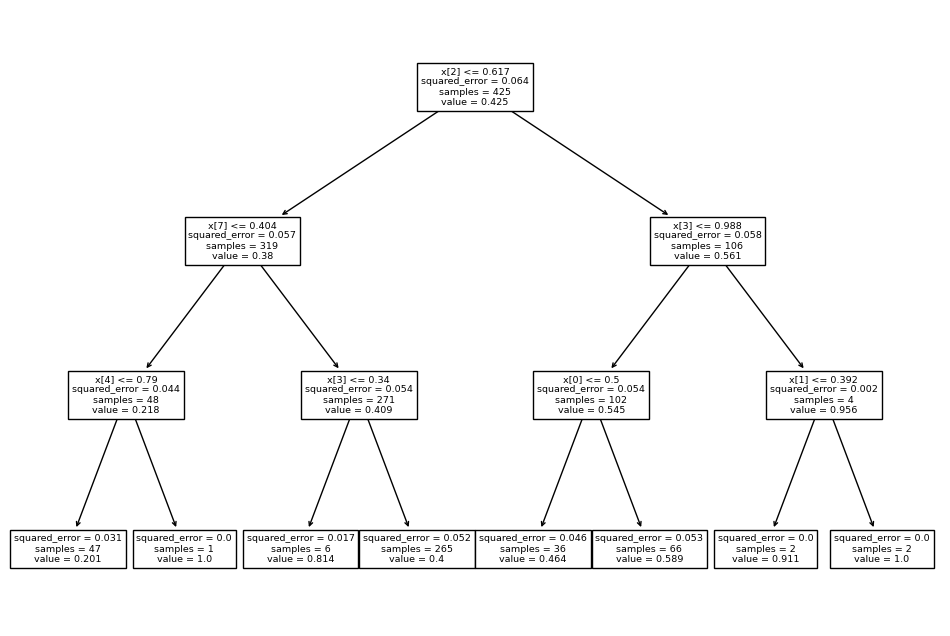

In [688]:
print(type(X_test))
plt.figure(figsize=(12, 8))
plot_tree(dt)

# RANDOM FOREST

### hyperparameter tuning

In [691]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint
import numpy as np

In [692]:
# Initialize a basic RandomForestRegressor with a fixed random state for reproducibility
rf = RandomForestRegressor(random_state=42)

# Print the current default parameters of the RandomForestClassifier
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [693]:
# --- Hyperparameter Grid Setup for Randomized Search ---

# Define a range of hyperparameters to test in the RandomizedSearchCV
# List of potential values for the number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start=3, stop=100, num=10)]

# Maximum depth of each tree
max_depth = [int(x) for x in np.linspace(3, 110, num=11)]
max_depth.append(None)  # Include None to allow unlimited depth

# Minimum samples required to split a node
min_samples_split = [2, 5, 10]

# Combine all parameters into a dictionary for randomized search
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split}

# Display the parameter grid
pprint(random_grid)

{'max_depth': [3, 13, 24, 35, 45, 56, 67, 77, 88, 99, 110, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [3, 13, 24, 35, 46, 56, 67, 78, 89, 100]}


In [694]:
# --- Randomized Search for Hyperparameter Tuning ---
# Instantiate a new RandomForestClassifier as a base model for tuning
rf = RandomForestRegressor()

# Initialize RandomizedSearchCV with the random grid, 3-fold cross-validation,
# 100 different parameter combinations, and verbose output for tracking progress
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=42)

# Fit the randomized search model to the training data
rf_random.fit(X_train, y_train)

# Retrieve the best parameters from the randomized search
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END .max_depth=77, min_samples_split=5, n_estimators=46; total time=   0.1s
[CV] END .max_depth=77, min_samples_split=5, n_estimators=46; total time=   0.2s
[CV] END .max_depth=77, min_samples_split=5, n_estimators=46; total time=   0.1s
[CV] END .max_depth=13, min_samples_split=5, n_estimators=24; total time=   0.1s
[CV] END .max_depth=13, min_samples_split=5, n_estimators=24; total time=   0.1s
[CV] END .max_depth=13, min_samples_split=5, n_estimators=24; total time=   0.1s
[CV] END .max_depth=99, min_samples_split=5, n_estimators=56; total time=   0.2s
[CV] END .max_depth=99, min_samples_split=5, n_estimators=56; total time=   0.2s
[CV] END .max_depth=99, min_samples_split=5, n_estimators=56; total time=   0.2s
[CV] END max_depth=110, min_samples_split=2, n_estimators=24; total time=   0.1s
[CV] END max_depth=110, min_samples_split=2, n_estimators=24; total time=   0.1s
[CV] END max_depth=110, min_samples_split=2, n

{'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 3}

In [706]:
# --- Model Evaluation Function ---
# Define a function to evaluate the model performance using Mean Absolute Error (MAE), Mean squared Error, R-squared

# Define a function to evaluate model performance for regression

def evaluate(model, X, y):
    predictions = model.predict(X)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    return mae, mse, r2

In [704]:
# --- Baseline Model Evaluation ---

# Initialize a basic RandomForestClassifier with minimal tuning (10 estimators)
base_model = RandomForestRegressor(n_estimators=10, random_state=42, max_depth=3)
base_model.fit(X_train, y_train)

# Evaluate the baseline model on the test data
base_mae, base_mse, base_r2 = evaluate(base_model, X_test, y_test)

# Evaluate the best model from the randomized search on the test data
best_random = rf_random.best_estimator_
random_mae, random_mse, random_r2 = evaluate(best_random, X_test, y_test)

# Print the improvement in R2 score with the best randomized model over the baseline

print('Baseline MAE: {:.2f}, MSE: {:.2f}, R²: {:.2f}'.format(base_mae, base_mse, base_r2))
print('Best Random Model MAE: {:.2f}, MSE: {:.2f}, R²: {:.2f}'.format(random_mae, random_mse, random_r2))

# Beispiel für Verbesserung in MAE
print('Improvement in MAE: {:.2f}.'.format(base_mae - random_mae))

Baseline MAE: 0.18, MSE: 0.05, R²: 0.15
Best Random Model MAE: 0.18, MSE: 0.05, R²: 0.14
Improvement in MAE: 0.00.


In [708]:
# --- Hyperparameter Grid Setup for Grid Search ---
# Define a smaller parameter grid for a more exhaustive grid search around the best randomized parameters
param_grid = {
    'max_depth': [2, 3, 4, 5, 14],
    'min_samples_split': [2, 3, 4, 5, 6],
    'n_estimators': [80, 90, 100, 110, 120]}

# Instantiate a new RandomForestClassifier as a base model for grid search
rf = RandomForestRegressor()

# Initialize GridSearchCV with the parameter grid, 3-fold cross-validation,
# and parallel processing for faster execution
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best parameters from the grid search
grid_search.best_params_

# Evaluate the best model from the grid search on the test data
best_grid = grid_search.best_estimator_

# Optional: Print the improvement in R² Score over a baseline
print('Improvement in R² Score over baseline: {:0.2f}'.format(r2 - baseline_r2))
grid_accuracy = evaluate(best_grid, X_test, y_test)



Fitting 3 folds for each of 125 candidates, totalling 375 fits


NameError: name 'baseline_r2' is not defined

In [ ]:
# Print the improvement in accuracy with the best grid model over the baseline
print('Improvement of {:0.2f}%.'.format(100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [ ]:
# our original best working model
rf= RandomForestRegressor(n_estimators=10, random_state=0, max_depth=3)
rf.fit(X_train, y_train)

In [ ]:
y_pred_rf= rf.predict(X_test)

In [ ]:
print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", rf.score(X_test_norm, y_test))

In [ ]:
rf = RandomForestRegressor(n_estimators=10, random_state=0)
rf.fit(X_train, y_train)

# ONE TREE
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[9], filled=True)
plt.show()

In [ ]:
# adaptive boosting

ada_cl = AdaBoostClassifier(RandomForestClassifier(max_depth=10),
                            n_estimators=3)

In [ ]:
ada_cl.fit(X_train_norm, y_train)

In [ ]:
y_pred_abc = ada_cl.predict(X_test_norm)